### Import all dependencies

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import the Dataset

In [111]:
car_data = pd.read_csv("data/car-sales-data.csv")

In [112]:
# view its head
car_data.head()

,Make,Colour,Odometer (KM),Doors,Price
0,Honda,White,35431.0,4.0,15323.0
1,BMW,Blue,192714.0,5.0,19943.0
2,Honda,White,84714.0,4.0,28343.0
3,Toyota,White,154365.0,4.0,13434.0
4,Nissan,Blue,181577.0,3.0,14043.0


## EDA

### Data Insights

In [113]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           951 non-null    object 
 1   Colour         950 non-null    object 
 2   Odometer (KM)  950 non-null    float64
 3   Doors          950 non-null    float64
 4   Price          950 non-null    float64
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


- The dataset is formed of 1000 rows (entries) and 5 columns (features).

In [114]:
# checking null values
car_data.isnull().sum()

Make             49
Colour           50
Odometer (KM)    50
Doors            50
Price            50
dtype: int64

- There are ~50 missing values (5%) in all categories. 

In [115]:
car_data.dtypes

Make              object
Colour            object
Odometer (KM)    float64
Doors            float64
Price            float64
dtype: object

- 'Make' and 'Colour' features are non-numerical values. This will be fixed by encoding. 

### Data Visualization

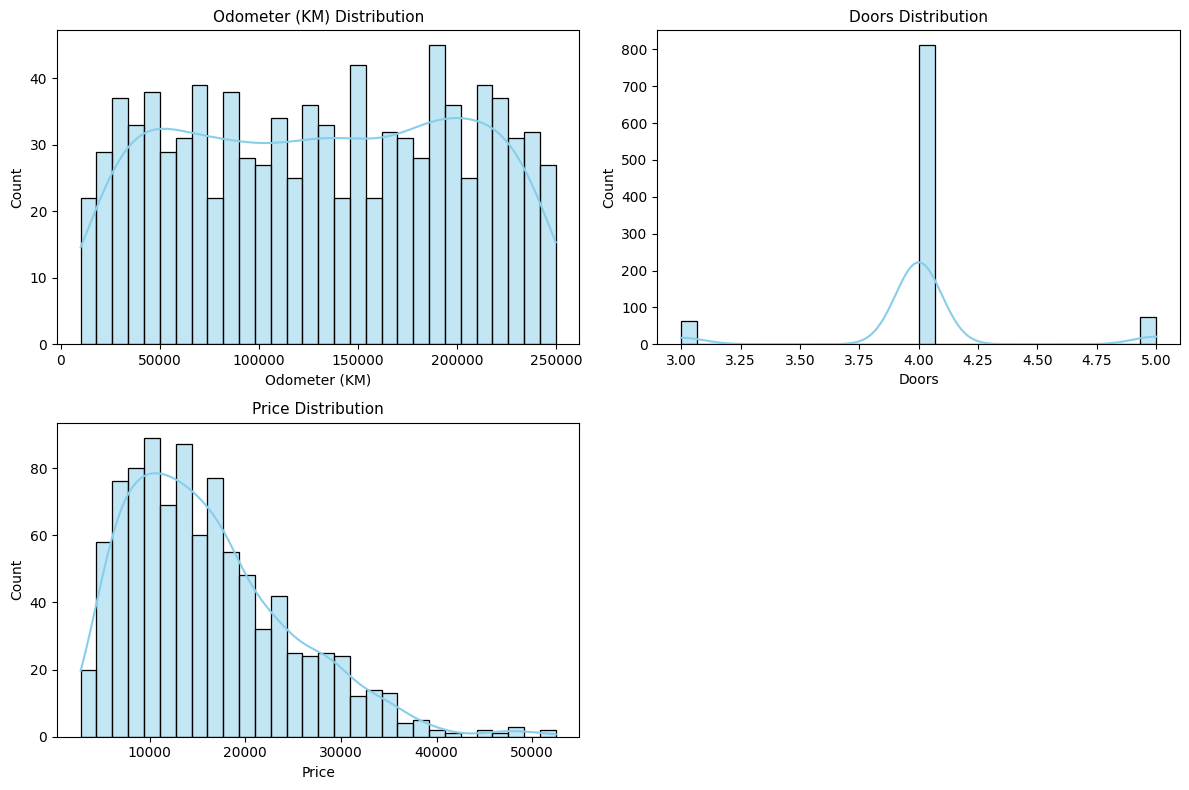

In [116]:
# Distribution Plots for Numerical Features

numeric_cols = ['Odometer (KM)', 'Doors', 'Price']

# calculate grid size (2 plots per row)
rows = (len(numeric_cols) + 1) // 2  

fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(numeric_cols):
    sns.histplot(car_data[col], kde=True, bins=30, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col} Distribution', fontsize=11)

# hide any empty subplot 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


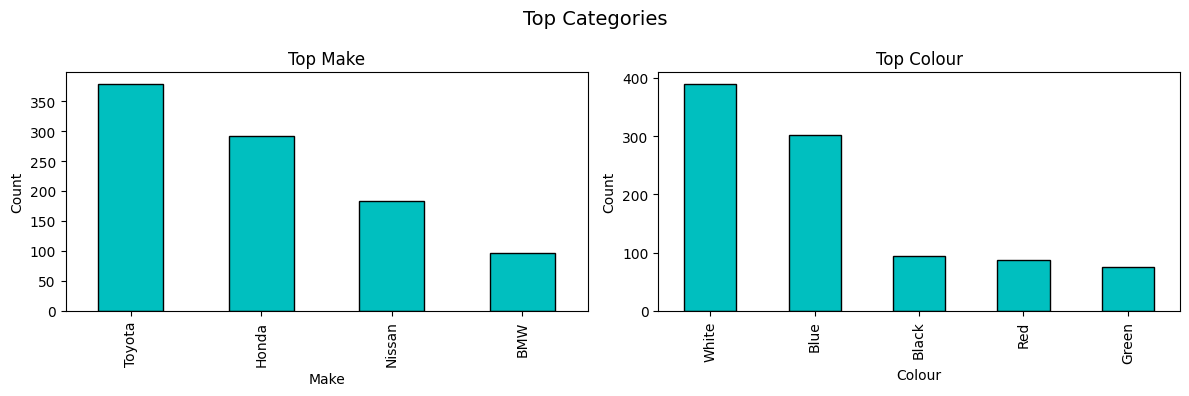

In [117]:
# Bar Plots for Categorical Features

categ_cols = ['Make', 'Colour']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Top Categories', fontsize=14)
plt.subplots_adjust(wspace=0.4)

for i, col in enumerate(categ_cols):
    car_data[col].value_counts().head(10).plot(kind='bar', ax=axes[i], color='c', edgecolor='black')
    axes[i].set_title(f'Top {col}')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Numerical Features Correlation with Price

In [118]:
car_data[['Odometer (KM)', 'Doors', 'Price']].corr()['Price'].sort_values(ascending=False)

Price            1.000000
Doors            0.243104
Odometer (KM)   -0.405649
Name: Price, dtype: float64

The car's Odometer (KM) has a moderate negative correlation with its Price, suggesting that higher mileage significantly contributes to a lower price. The number of Doors has only a weak positive correlation with price, meaning it's a much less influential factor than the mileage.

## Data Preprocessing

In [119]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split

### Removing Rows with Missing 'Price' Values  

In [120]:
car_data.dropna(subset=['Price'], inplace=True)
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           903 non-null    object 
 1   Colour         904 non-null    object 
 2   Odometer (KM)  902 non-null    float64
 3   Doors          903 non-null    float64
 4   Price          950 non-null    float64
dtypes: float64(3), object(2)
memory usage: 44.5+ KB


In [121]:
# log-transform target to handle skewness of prices
car_data['Price'] = np.log1p(car_data['Price'])  # log1p handles zero values 

### Building a Pipeline

In [122]:
categorical_features = ['Make', 'Colour']
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [123]:
door_feature = ["Doors"]
door_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=4))
])

In [124]:
numeric_features = ["Odometer (KM)"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [125]:
preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, categorical_features),
        ("door", door_transformer, door_feature),
        ("num", numeric_transformer, numeric_features)
    ])

## Models Building

In [126]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Data Splitting

In [127]:
car_data_X = car_data.drop('Price', axis=1)
car_data_y = car_data['Price']

In [128]:
car_X_train, car_X_test, car_y_train, car_y_test = train_test_split(car_data_X, 
                                                                    car_data_y, 
                                                                    test_size=0.2, random_state=42)

In [129]:
car_X_train.shape, car_X_test.shape, car_y_train.shape, car_y_test.shape

((760, 4), (190, 4), (760,), (190,))

### Models

In [130]:
regression_models = {
    "Ridge": Ridge(alpha=1.0),
    "SVR_linear": SVR(kernel="linear", C=1.0),
    "SVR_rbf": SVR(kernel="rbf", C=10, gamma='scale'),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
}

regression_results = {}

### Models Training

In [137]:
from sklearn.metrics import r2_score

np.random.seed(42)

for model_name, model in regression_models.items():
    model_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    model_pipeline.fit(car_X_train, car_y_train)

    # evaluate on test set
    test_preds = model_pipeline.predict(car_X_test)
    test_score = r2_score(car_y_test, test_preds)
    regression_results[model_name] = test_score
    print(f"{model_name} Test R²: {test_score:.4f}")

Ridge Test R²: 0.2143
SVR_linear Test R²: 0.1570
SVR_rbf Test R²: 0.1590
Random Forest Regressor Test R²: 0.1898


- Ridge model has the highest R2 score, so it will be chosen for further evaluation.

## Evaluation

In [132]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

ridge_pipeline.fit(car_X_train, car_y_train)

# make predictions
car_y_preds = ridge_pipeline.predict(car_X_test)
real_preds = np.expm1(car_y_preds) # to get the real predicted prices

real_preds[:20]

array([16508.00192431, 20434.88362276, 10397.05882459,  7946.59726899,
        8944.34964389, 10372.76659618, 13654.82935156, 11987.12526432,
       17643.9521231 , 12666.77083855,  7805.40488742, 14691.35873185,
       10931.52474892, 12338.55592261, 12769.35672229, 14525.62109194,
       14028.9191593 ,  9844.37733339, 10647.29709781, 10661.2181954 ])

In [133]:
mse = mean_squared_error(car_y_test, car_y_preds)
mse

0.24189105761383475

In [134]:
mae = mean_absolute_error(car_y_test, car_y_preds)
mae

0.4024529381464668

In [135]:
r2 = r2_score(car_y_test, car_y_preds)
r2

0.2142609780974818

### Model Evaluation Discussion

The relatively low R² score (~ 0.21) and moderate error values (MSE = 0.24, MAE = 0.40) indicate that the model captures only a limited portion of the variance in car prices.

This performance is primarily due to the insufficient size and quality of the dataset, which restricts the model’s ability to learn complex relationships between features and target values. Thus, the low scores primarily reflect **dataset insufficiency** rather than **model inefficiency**.

With more diverse and representative data, the model’s accuracy and generalization would likely improve significantly.